# Calidad de los datos para tabla Players

## 0. Librerias

In [138]:
import sqlite3
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Extraccion de los datos

In [139]:
tabla = 'Team'

In [140]:
conn = sqlite3.connect('database.sqlite')
data = pd.read_sql_query(f"SELECT * FROM {tabla}", conn)

In [141]:
data.shape

(299, 5)

In [142]:
data.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [143]:
data.dtypes

id                    int64
team_api_id           int64
team_fifa_api_id    float64
team_long_name       object
team_short_name      object
dtype: object

## 1.1. Columnas numericas 

In [144]:
#number_cols = data.dtypes[(data.dtypes == np.int64) | (data.dtypes == np.float64)].index
integer_cols = data.select_dtypes(include = ['int']).columns
float_cols = data.select_dtypes(include = ['float']).columns

number_cols = data.select_dtypes(include = ['int','float']).columns
number_cols 

Index(['id', 'team_api_id', 'team_fifa_api_id'], dtype='object')

In [145]:
data[number_cols].describe()

,id,team_api_id,team_fifa_api_id
count,299.000000,299.000000,288.000000
mean,23735.301003,12340.521739,21534.305556
std,15167.914719,25940.411135,42456.439408
min,1.000000,1601.000000,1.000000
25%,9552.500000,8349.000000,178.750000
50%,22805.000000,8655.000000,673.500000
75%,36250.500000,9886.500000,1910.750000
max,51606.000000,274581.000000,112513.000000


## 1.2. Columnas categoricas 

In [146]:
#non_number_cols = data.columns.difference(number_cols) 
#non_number_cols = data.dtypes[(data.dtypes != np.int64) & (data.dtypes != np.float64)].index 

object_cols = data.select_dtypes(include = ['object']).columns
boolean_cols = data.select_dtypes(include = ['bool']).columns
date_cols = data.select_dtypes(include = ['datetime']).columns

non_number_cols = data.select_dtypes(include = ['object','bool','datetime']).columns
non_number_cols

Index(['team_long_name', 'team_short_name'], dtype='object')

In [147]:
for col in date_cols:
    data[col] = pd.to_datetime(data[col], errors = 'coerce')

In [148]:

data[date_cols].head(3)

""
0
1
2


In [149]:
data[non_number_cols].info

<bound method DataFrame.info of          team_long_name team_short_name
0              KRC Genk             GEN
1          Beerschot AC             BAC
2      SV Zulte-Waregem             ZUL
3      Sporting Lokeren             LOK
4     KSV Cercle Brugge             CEB
..                  ...             ...
294       FC St. Gallen             GAL
295             FC Thun             THU
296         Servette FC             SER
297  FC Lausanne-Sports             LAU
298              Lugano             LUG

[299 rows x 2 columns]>

## 1.3 Correlacion

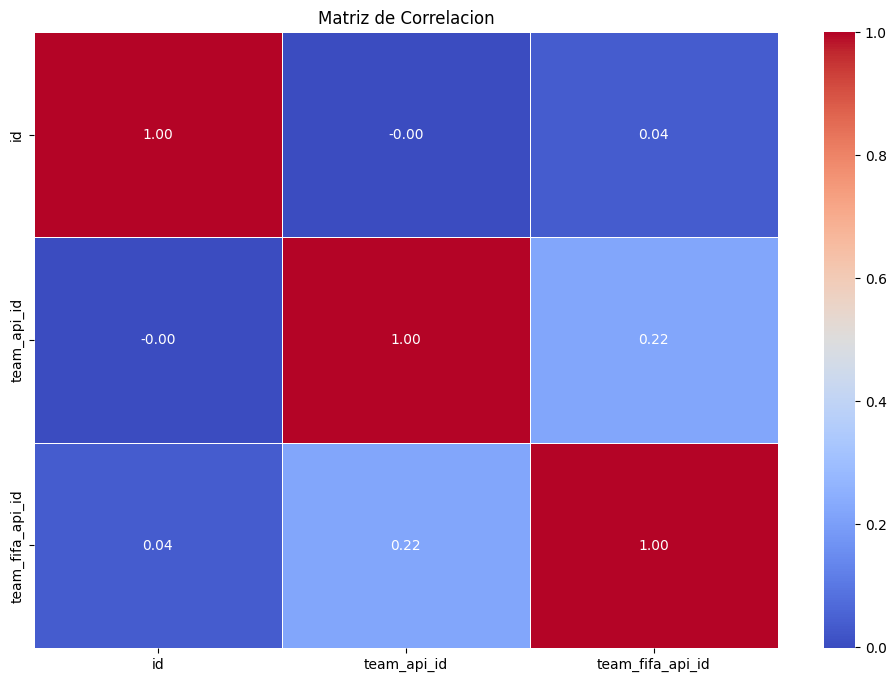

In [150]:
import numpy as np

matriz_correlaciones = data[number_cols].corr()

mask = np.triu(np.ones_like(matriz_correlaciones, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(matriz_correlaciones, mask=None, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Matriz de Correlacion")
plt.show()

# 2. Calidad de los datos

In [151]:
data_t = data.copy()
data_t.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


## 2.1. Completitud

In [152]:
data_t.isnull().sum().sort_values(ascending=False)

team_fifa_api_id    11
id                   0
team_api_id          0
team_long_name       0
team_short_name      0
dtype: int64

In [153]:
print("Porcentaje nulos por columna: ")
(100 * data_t.isnull().sum()/data_t.shape[0]).sort_values(ascending=False)

Porcentaje nulos por columna: 


team_fifa_api_id    3.67893
id                  0.00000
team_api_id         0.00000
team_long_name      0.00000
team_short_name     0.00000
dtype: float64

In [154]:
data_t = data_t.dropna()

In [155]:
data_t.dropna(subset = non_number_cols, inplace = True )

In [156]:
for col in number_cols:
    data_t[col].fillna(data_t[col].mean())

In [157]:
data_t.isnull().sum().sort_values(ascending=False)

id                  0
team_api_id         0
team_fifa_api_id    0
team_long_name      0
team_short_name     0
dtype: int64

## 2.2. Unicidad

In [158]:
for col in non_number_cols:
    num_duplicated = data_t.duplicated(subset = col).sum()
    print(f"{col}: {num_duplicated}")

team_long_name: 3
team_short_name: 37


In [159]:
data.groupby('team_long_name').size().sort_values(ascending=False).head()

team_long_name
Polonia Bytom           2
Royal Excel Mouscron    2
Widzew Łódź             2
1. FC Köln              1
1. FC Nürnberg          1
dtype: int64

In [160]:
duplicados = data_t[data_t.duplicated(subset=['team_long_name', 'team_short_name'], keep=False)]
duplicados


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name


In [161]:
duplicados_por_columna = {
    col: data_t[col].duplicated().sum()
    for col in data_t.columns
}
duplicados_por_columna = pd.Series(duplicados_por_columna).sort_values(ascending=False)
duplicados_por_columna


team_short_name     37
team_long_name       3
team_fifa_api_id     3
id                   0
team_api_id          0
dtype: int64

In [162]:
data.groupby('team_fifa_api_id').size().sort_values(ascending=False).head()

team_fifa_api_id
301.0       2
111429.0    2
111560.0    2
7.0         1
9.0         1
dtype: int64

In [163]:
data_t.loc[data_t.duplicated(keep=False)]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name


In [164]:
print(f"Porcentage de duplicados: {data_t.duplicated(keep=False).sum() / data.shape[0] * 100:.2f}%")

Porcentage de duplicados: 0.00%


In [165]:
data_t.drop_duplicates(keep = 'first', inplace = True)

In [166]:
data_t.duplicated(keep=False).sum()

np.int64(0)

## 2.3. Consistencia

In [167]:
data_t.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [177]:
data_t.loc[data_t.duplicated(subset=["team_long_name"], keep=False)]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
15,16,9996,111560.0,Royal Excel Mouscron,MOU
24,2510,274581,111560.0,Royal Excel Mouscron,MOP
182,31444,8031,111429.0,Polonia Bytom,POB
183,31445,8020,111429.0,Polonia Bytom,GOR
189,31451,8244,301.0,Widzew Łódź,LOD
199,32409,8024,301.0,Widzew Łódź,WID


In [ ]:
def check_consistency(df: pd.DataFrame) -> dict:
    res = {}

    # 1) team_api_id → long_name único
    g = df.groupby("team_api_id")["team_long_name"].nunique(dropna=False)
    ids_conflict_long = g[g > 1].index
    res["team_api_id→long_name_inconsistente"] = df[df["team_api_id"].isin(ids_conflict_long)].sort_values(["team_api_id","team_long_name"])

    # 2) team_api_id → short_name único
    g = df.groupby("team_api_id")["team_short_name"].nunique(dropna=False)
    ids_conflict_short = g[g > 1].index
    res["team_api_id→short_name_inconsistente"] = df[df["team_api_id"].isin(ids_conflict_short)].sort_values(["team_api_id","team_short_name"])

    # 3) team_api_id → fifa_id único (ignorando NaN)
    non_null = df[~df["team_fifa_api_id"].isna()]
    g = non_null.groupby("team_api_id")["team_fifa_api_id"].nunique(dropna=True)
    ids_conflict_fifa = g[g > 1].index
    res["team_api_id→team_fifa_api_id_inconsistente"] = df[df["team_api_id"].isin(ids_conflict_fifa)].sort_values(["team_api_id","team_fifa_api_id"])

    # 4) long_name → team_api_id único (opcional; puede haber homónimos)
    g = df.groupby("team_long_name")["team_api_id"].nunique(dropna=False)
    long_conflict = g[g > 1].index
    res["long_name→team_api_id_inconsistente_(posible_homónimo)"] = df[df["team_long_name"].isin(long_conflict)].sort_values(["team_long_name","team_api_id"])

    # 5) Detección de espacios a los lados en nombres
    mask_trim_long  = df["team_long_name"].notna()  & (df["team_long_name"]  != df["team_long_name"].str.strip())
    mask_trim_short = df["team_short_name"].notna() & (df["team_short_name"] != df["team_short_name"].str.strip())
    res["espacios_laterales_long_name"]  = df[mask_trim_long][["team_api_id","team_long_name"]]
    res["espacios_laterales_short_name"] = df[mask_trim_short][["team_api_id","team_short_name"]]

    # 6) Normalización inconsistente de mayúsculas en short_name (mismo ID, distintos casing)
    g = df.assign(_short_norm = df["team_short_name"].str.upper()).groupby("team_api_id")["_short_norm"].nunique()
    ids_casing = g[g > 1].index
    res["casing_inconsistente_short_name_por_team_api_id"] = df[df["team_api_id"].isin(ids_casing)][["team_api_id","team_short_name"]].sort_values(["team_api_id","team_short_name"])

    # Resumen
    res["resumen_consistencia"] = pd.DataFrame({
        "check": [
            "team_api_id→long_name único",
            "team_api_id→short_name único",
            "team_api_id→team_fifa_api_id único (sin NaN)",
            "long_name→team_api_id único (homónimos?)",
            "espacios en long_name",
            "espacios en short_name",
            "casing inconsistente short_name"
        ],
        "n_registros_afectados": [
            len(res["team_api_id→long_name_inconsistente"]),
            len(res["team_api_id→short_name_inconsistente"]),
            len(res["team_api_id→team_fifa_api_id_inconsistente"]),
            len(res["long_name→team_api_id_inconsistente_(posible_homónimo)"]),
            len(res["espacios_laterales_long_name"]),
            len(res["espacios_laterales_short_name"]),
            len(res["casing_inconsistente_short_name_por_team_api_id"]),
        ]
    })

    return res

{'team_api_id→long_name_inconsistente': Empty DataFrame
 Columns: [id, team_api_id, team_fifa_api_id, team_long_name, team_short_name]
 Index: [],
 'team_api_id→short_name_inconsistente': Empty DataFrame
 Columns: [id, team_api_id, team_fifa_api_id, team_long_name, team_short_name]
 Index: [],
 'team_api_id→team_fifa_api_id_inconsistente': Empty DataFrame
 Columns: [id, team_api_id, team_fifa_api_id, team_long_name, team_short_name]
 Index: [],
 'long_name→team_api_id_inconsistente_(posible_homónimo)':         id  team_api_id  team_fifa_api_id        team_long_name  \
 183  31445         8020          111429.0         Polonia Bytom   
 182  31444         8031          111429.0         Polonia Bytom   
 15      16         9996          111560.0  Royal Excel Mouscron   
 24    2510       274581          111560.0  Royal Excel Mouscron   
 199  32409         8024             301.0           Widzew Łódź   
 189  31451         8244             301.0           Widzew Łódź   
 
     team_short

In [176]:
res = check_consistency(data)
for check, df_issues in res.items():
    if check != "resumen_consistencia" and not df_issues.empty:
        print(f"\n\n--- {check} ---")
        print(df_issues)
        
res["resumen_consistencia"]



--- long_name→team_api_id_inconsistente_(posible_homónimo) ---
        id  team_api_id  team_fifa_api_id        team_long_name  \
183  31445         8020          111429.0         Polonia Bytom   
182  31444         8031          111429.0         Polonia Bytom   
15      16         9996          111560.0  Royal Excel Mouscron   
24    2510       274581          111560.0  Royal Excel Mouscron   
199  32409         8024             301.0           Widzew Łódź   
189  31451         8244             301.0           Widzew Łódź   

    team_short_name  
183             GOR  
182             POB  
15              MOU  
24              MOP  
199             WID  
189             LOD  


,check,n_registros_afectados
0,team_api_id→long_name único,0
1,team_api_id→short_name único,0
2,team_api_id→team_fifa_api_id único (sin NaN),0
3,long_name→team_api_id único (homónimos?),6
4,espacios en long_name,0
5,espacios en short_name,0
6,casing inconsistente short_name,0


## 2.4. Validez

In [169]:
data_t.dtypes

id                    int64
team_api_id           int64
team_fifa_api_id    float64
team_long_name       object
team_short_name      object
dtype: object

In [170]:
data_t.value_counts()

id     team_api_id  team_fifa_api_id  team_long_name      team_short_name
1      9987         673.0             KRC Genk            GEN                1
2      9993         675.0             Beerschot AC        BAC                1
3      10000        15005.0           SV Zulte-Waregem    ZUL                1
4      9994         2007.0            Sporting Lokeren    LOK                1
5      9984         1750.0            KSV Cercle Brugge   CEB                1
                                                                            ..
49124  10243        894.0             FC Zürich           ZUR                1
49479  10190        898.0             FC St. Gallen       GAL                1
49837  10191        1715.0            FC Thun             THU                1
50201  9777         324.0             Servette FC         SER                1
50204  7730         1862.0            FC Lausanne-Sports  LAU                1
Name: count, Length: 288, dtype: int64